In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize the Earth Engine module
ee.Initialize()

def calculate_winter_mean_anomalies(df, baseline_start, baseline_end):
    # Filter data for winter months only (December, January, February)
    df_winter = df[df.index.month.isin([12, 1, 2])]
    # Calculate mean for each winter
    df_winter_mean = df_winter.groupby(df_winter.index.year).mean()
    
    # Calculate baseline mean
    baseline = df_winter_mean[(df_winter_mean.index >= baseline_start) & (df_winter_mean.index <= baseline_end)]
    baseline_avg = baseline.mean()
    
    # Calculate anomalies as the difference from the baseline average
    anomalies = df_winter_mean - baseline_avg
    return anomalies

def fetch_daily_variable(lat, lon, variable, start_date, end_date):
    point = ee.Geometry.Point(lon, lat)
    dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .select(variable) \
        .filterBounds(point)

    def to_feature(image):
        reduction = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=11000  # Adjust scale to match dataset resolution
        )
        value = reduction.get(variable)
        return ee.Feature(None, {'value': value, 'time': image.date().format()})

    data_feat = dataset.map(to_feature)
    data_list = data_feat.reduceColumns(ee.Reducer.toList(2), ['time', 'value']).getInfo()['list']
    df = pd.DataFrame(data_list, columns=["DateTime", variable])
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    return df

def fetch_and_process(lat, lon, start='1950-01-01', end=datetime.now().strftime('%Y-%m-%d')):
    snowfall = fetch_daily_variable(lat, lon, 'snowfall_sum', start, end)
    snow_depth = fetch_daily_variable(lat, lon, 'snow_depth', start, end)
    air_temp = fetch_daily_variable(lat, lon, 'temperature_2m', start, end) - 273.15  # Convert from K to C

    baseline_start = 1950
    baseline_end = 1980
    
    snowfall_anom = calculate_winter_mean_anomalies(snowfall, baseline_start, baseline_end)
    snow_depth_anom = calculate_winter_mean_anomalies(snow_depth, baseline_start, baseline_end)
    air_temp_anom = calculate_winter_mean_anomalies(air_temp, baseline_start, baseline_end)

    return snowfall_anom, snow_depth_anom, air_temp_anom

# Set the latitude and longitude for a location in Scotland
lat, lon = 56.87514, -3.37408 # Approximate coordinates for a location in Scotland -3.37408, 56.87514
snowfall_anom, snow_depth_anom, air_temp_anom = fetch_and_process(lat, lon)



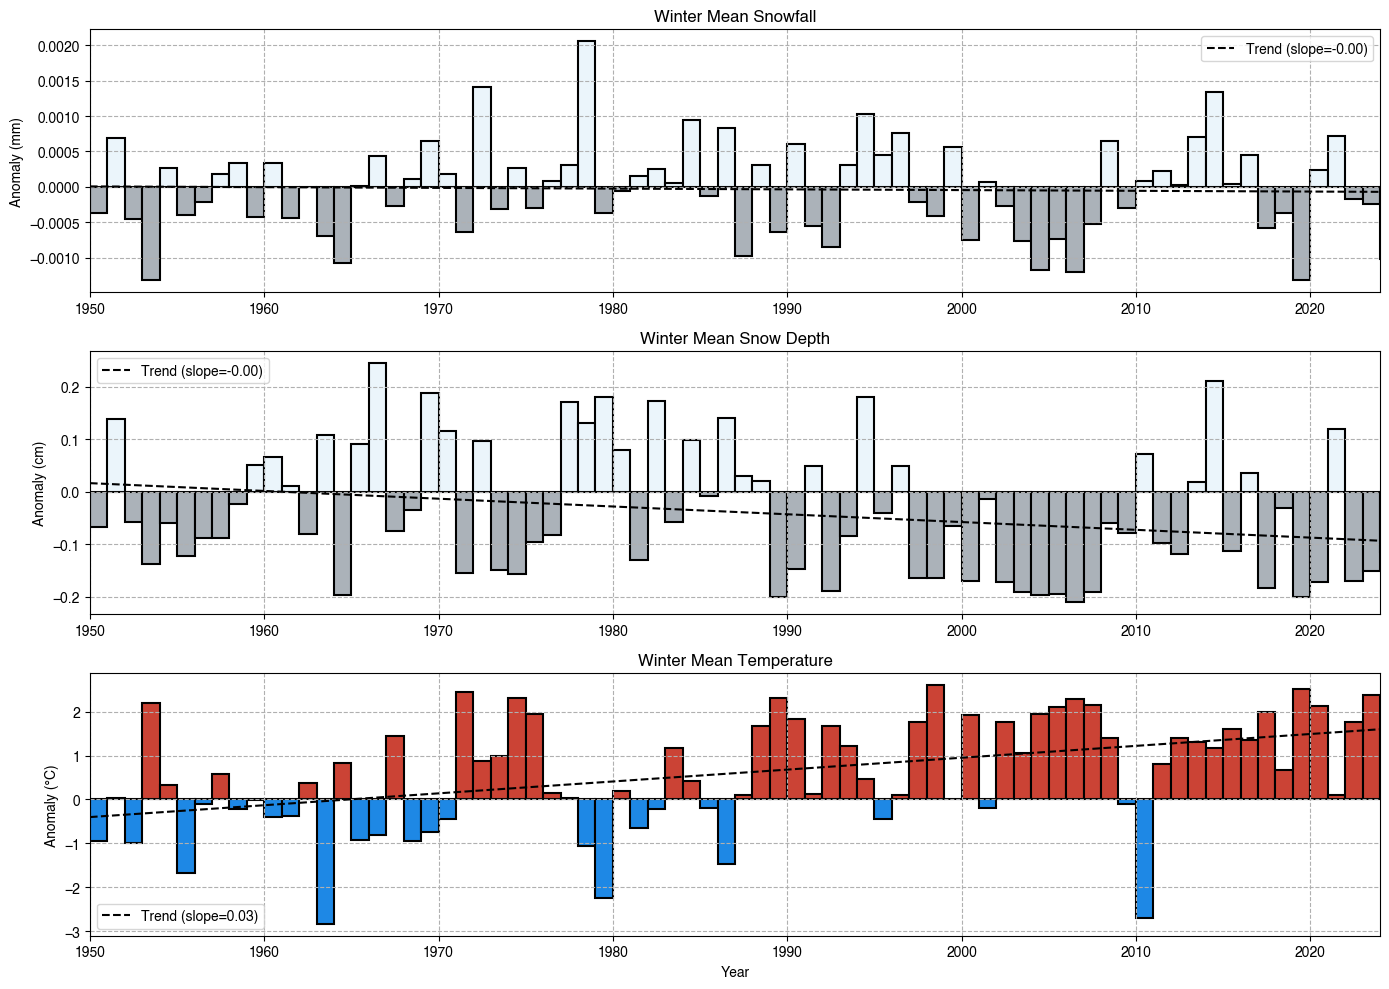

In [17]:
import numpy as np
from scipy.stats import linregress

#set font as helvetica
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
# Plotting each variable in a subplot using bar graphs
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
bar_width = 1.0  # Set bar width to fill the entire year

# Define a function to add a trend line
def add_trend_line(ax, data, color):
    x = np.array(data.index)
    y = data.values.flatten()
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax.plot(x, intercept + slope * x, color=color, label=f'Trend (slope={slope:.2f})', linestyle='--')
    ax.legend()

# Function to determine bar colors based on anomaly values
def get_bar_colors(data, positive_color, negative_color):
    return [positive_color if value >= 0 else negative_color for value in data]

# Snowfall Anomalies Plot
colors_snowfall = get_bar_colors(snowfall_anom['snowfall_sum'], '#ebf5fb', '#abb2b9')    #           #ebf5fb  more snow,  #f39c12 
axs[0].bar(snowfall_anom.index, snowfall_anom['snowfall_sum'], color=colors_snowfall, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
axs[0].set_title('Winter Mean Snowfall')
axs[0].set_ylabel('Anomaly (mm)')
axs[0].grid(True, linestyle='--')
add_trend_line(axs[0], snowfall_anom['snowfall_sum'], 'k')
axs[0].set_xlim([1950, 2024])

# Snow Depth Anomalies Plot
colors_snow_depth = get_bar_colors(snow_depth_anom['snow_depth'], '#ebf5fb', '#abb2b9')
axs[1].bar(snow_depth_anom.index, snow_depth_anom['snow_depth'], color=colors_snow_depth, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
axs[1].set_title('Winter Mean Snow Depth')
axs[1].set_ylabel('Anomaly (cm)')
axs[1].grid(True, linestyle='--')
add_trend_line(axs[1], snow_depth_anom['snow_depth'], 'k')
axs[1].set_xlim([1950, 2024])

# Air Temperature Anomalies Plot
colors_air_temp = get_bar_colors(air_temp_anom['temperature_2m'], '#cb4335', '#1e88e5')
axs[2].bar(air_temp_anom.index, air_temp_anom['temperature_2m'], color=colors_air_temp, width=bar_width, align='edge', edgecolor='black', linewidth=1.5)
axs[2].set_title('Winter Mean Temperature')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Anomaly (°C)')
axs[2].grid(True, linestyle='--')
add_trend_line(axs[2], air_temp_anom['temperature_2m'], 'k')
axs[2].set_xlim([1950, 2024])



plt.tight_layout()
plt.show()


In [24]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Earth Engine module
ee.Initialize()

def fetch_daily_variable(lat, lon, variable, start_date, end_date):
    point = ee.Geometry.Point(lon, lat)
    dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(start_date, end_date) \
        .select(variable) \
        .filterBounds(point)

    def to_feature(image):
        reduction = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=11000)
        value = reduction.get(variable)
        return ee.Feature(None, {'value': value, 'time': image.date().format()})

    data_feat = dataset.map(to_feature)
    data_list = data_feat.reduceColumns(ee.Reducer.toList(2), ['time', 'value']).getInfo()['list']
    df = pd.DataFrame(data_list, columns=["DateTime", variable])
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    return df

def calculate_wind_speed(u_component, v_component):
    wind_speed_m_s = np.sqrt(u_component**2 + v_component**2)
    wind_speed_mph = wind_speed_m_s * 2.23694  # Convert m/s to mph
    return wind_speed_mph

def calculate_skiable_days(snow_depth, wind_speed):
    skiable = (snow_depth > 0.25) & (wind_speed < 30)
    return skiable.resample('Y').sum()  # Sum skiable days per year

def plot_skiable_days(skiable_data):
    fig, ax = plt.subplots(figsize=(14, 7), dpi=300)
    colors = ['blue', 'green', 'red']
    bottom = np.zeros(len(skiable_data[list(skiable_data.keys())[0]]))
    for i, (name, data) in enumerate(skiable_data.items()):
        ax.bar(data.index.year, data, bottom=bottom, color=colors[i], label=f'{name} Skiable Days')
        bottom += data.values

    ax.set_title('Skiable Days per Year Across Locations')
    ax.set_ylabel('Days')
    ax.set_xlabel('Year')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Define locations
locations = {
    "Glenshee": (56.875916, -3.377881), 
    "Glencoe": (56.61286, -4.84884),
    "Cairngorm": (57.1187, -3.6542) 
}

# Start and end dates
start_date = '1950-01-01'
end_date = '2024-12-31'

# Fetch and process data
skiable_data = {}
for name, (lat, lon) in locations.items():
    snow_depth = fetch_daily_variable(lat, lon, 'snow_depth', start_date, end_date)
    u_wind = fetch_daily_variable(lat, lon, 'u_component_of_wind_10m', start_date, end_date)
    v_wind = fetch_daily_variable(lat, lon, 'v_component_of_wind_10m', start_date, end_date)
    wind_speed = calculate_wind_speed(u_wind['u_component_of_wind_10m'], v_wind['v_component_of_wind_10m'])
    skiable_days = calculate_skiable_days(snow_depth['snow_depth'], wind_speed)
    skiable_data[name] = skiable_days



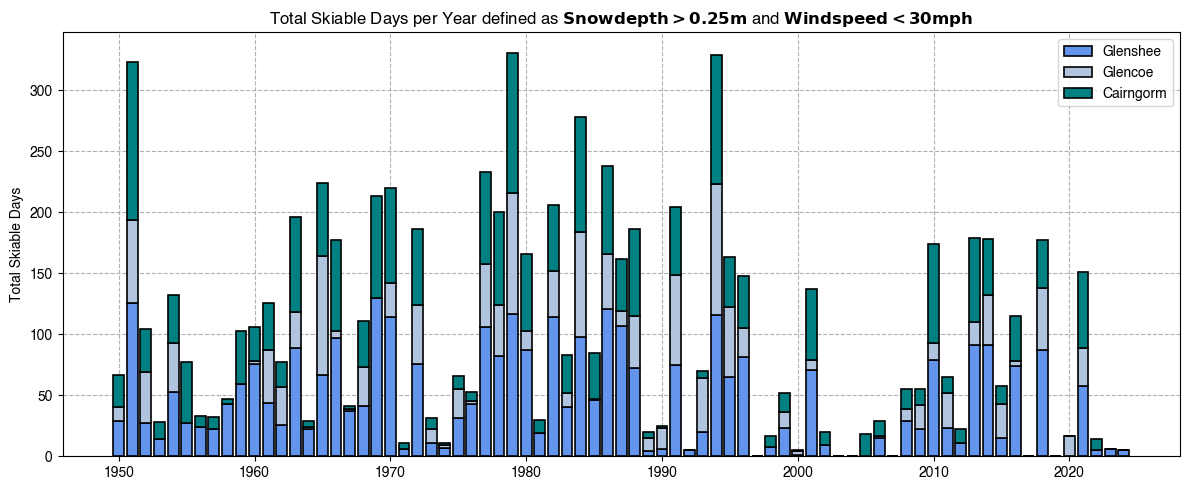

In [47]:
def plot_skiable_days(skiable_data):
    # change font to helvetica
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    fig, ax = plt.subplots(figsize=(12, 5))
    colors = ['cornflowerblue', 'lightsteelblue', 'teal']
    bottom = np.zeros(len(skiable_data[list(skiable_data.keys())[0]]))
    for i, (name, data) in enumerate(skiable_data.items()):
        ax.bar(data.index.year, data, bottom=bottom, color=colors[i], label=f'{name}', edgecolor='black', linewidth=1.2, zorder=2)
        bottom += data.values


    ax.set_ylabel('Total Skiable Days')
    ax.legend()
    ax.grid(True, linestyle='--', zorder=-4)
    ax.set_title(r'Total Skiable Days per Year defined as $\bf{Snowdepth > 0.25m}$ and $\bf{Windspeed < 30mph}$')
    plt.tight_layout()
    plt.show()

plot_skiable_days(skiable_data)